In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
import gpflow

import warnings
warnings.filterwarnings("ignore")

2025-04-13 08:13:27.007756: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 08:13:27.027176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744553607.048635   68618 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744553607.055362   68618 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-13 08:13:27.079318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [6]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

### setup

In [5]:
#############################################
# Setup
#############################################
# load observational data
obs = xr.open_dataset('wave2_obsStatistics_sudokuBiomes.nc')

# info on parameter names
params_lhc = pd.read_csv('/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt').drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

pft_param_names = {i: [f"{param}_{i}" for param in pft_params] for i in range(1, 15)}

# Biome info
file='/glade/u/home/linnia/ctsm6_ppe/utils/sudoku_biomes.nc'
biomes=xr.open_dataset(file)
biome_names = biomes.biome_names.values

import pickle
with open("/glade/u/home/linnia/ctsm6_ppe/utils/biome_pft_dict.pkl", "rb") as f:
    biome_pfts = pickle.load(f)



### Load NROY sets

In [7]:
indir = '/glade/work/linnia/CLM6-PPE/ctsm6_wave1/NROY/'
files = np.sort(glob.glob(indir + 'hmatch_mastersample_*'))
df_list = [pd.read_csv(f) for f in files]
master_sample = pd.concat(df_list, ignore_index=True)

### Emulate to check

In [4]:
infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)
lhc_pxb = ds_lhc.where(ds_lhc['crashed'] != 1, drop=True)
lai_lhc = lhc_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()
gpp_lhc = (60*60*24)*lhc_pxb.GPP_biome_amean.sel(year=slice('2001','2015')).mean(dim='year').compute()
biomass_lhc = (1/1000)*lhc_pxb.TOTVEGC_biome_amean.sel(year=slice('2000','2019')).mean(dim='year').compute()


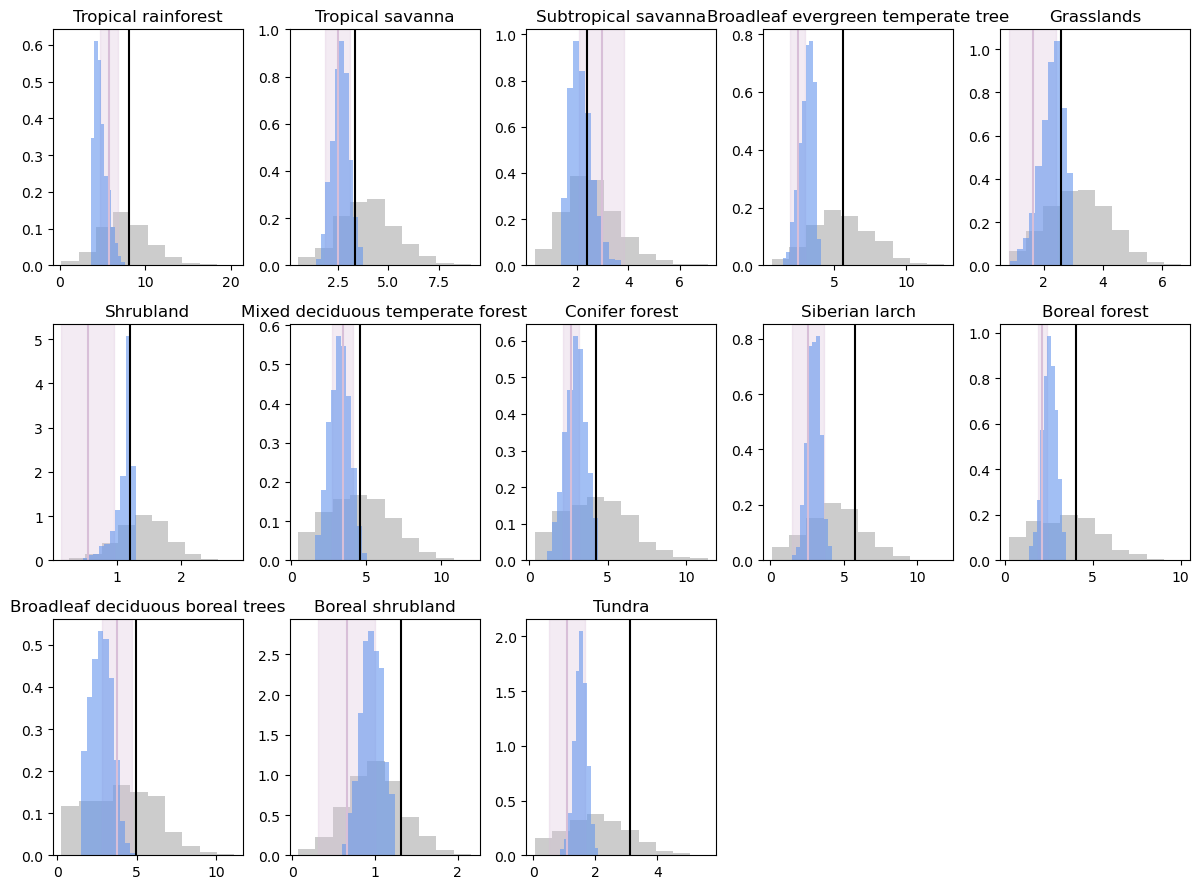

In [13]:
emulator_dir = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave2_biome/emulators_biomelai/'

plt.figure(figsize=(12,9))
for b, biome in enumerate(biome_names[1:],start=1):
    plt.subplot(3,5,b)

    obs_mean = obs.LAI_mean.sel(biome=b).values
    obs_var = obs.LAI_stdev.sel(biome=b).values**2

    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = master_sample[cols][:1000]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.hist(lai_lhc.isel(biome=b),color='grey',alpha=0.4,density=True)
    plt.axvspan(obs_mean-2*obs_var**0.5,obs_mean+2*obs_var**0.5,color='thistle',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    #plt.axvline(y_pred.numpy().flatten(),color='green')
    plt.axvline(lai_lhc.isel(biome=b,ens=0),color='k')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue',density=True)
    
    plt.title(biome)

plt.tight_layout()

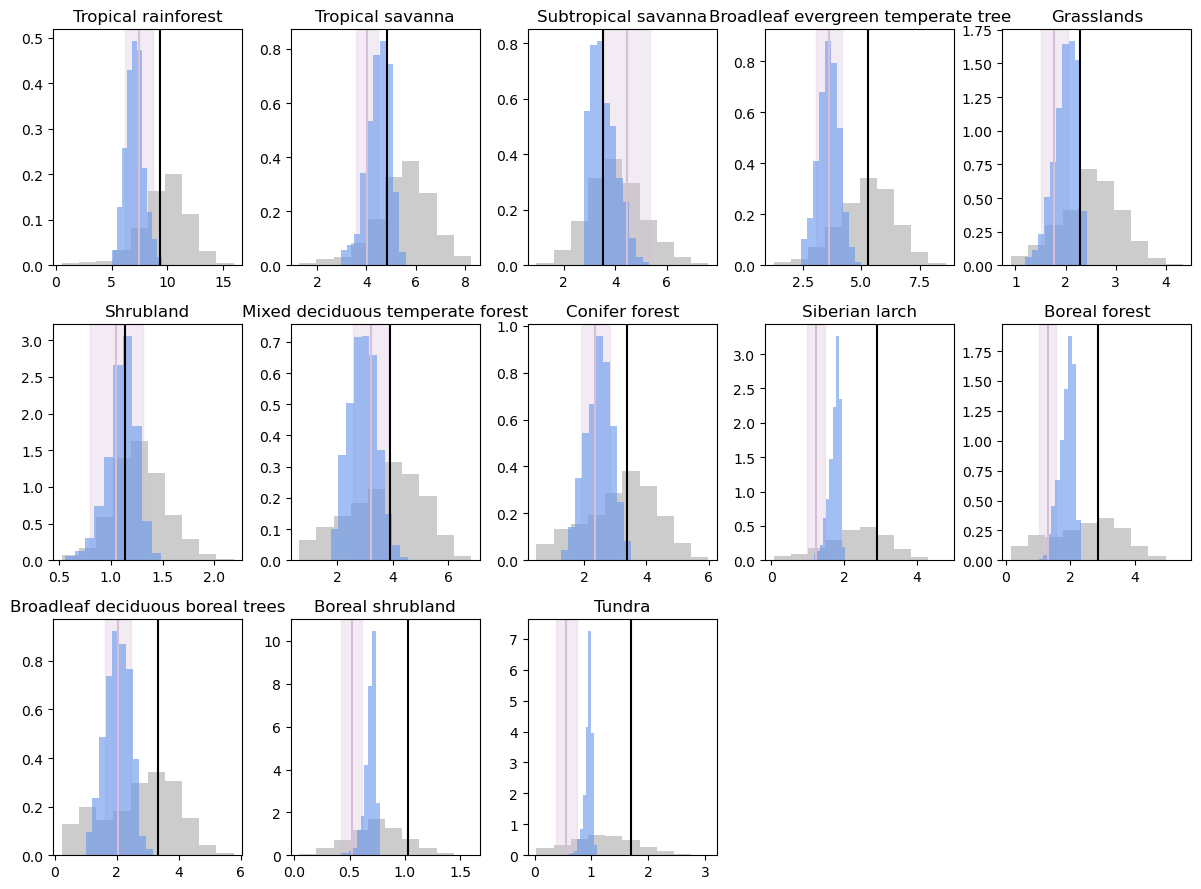

In [12]:
# emulate GPP
emulator_dir = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave2_biome/emulators_biomegpp/'

plt.figure(figsize=(12,9))
for b, biome in enumerate(biome_names[1:],start=1):
    plt.subplot(3,5,b)

    obs_mean = obs.GPP_mean.sel(biome=b).values
    obs_var = obs.GPP_stdev.sel(biome=b).values**2

    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = master_sample[cols][:1000]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.hist(gpp_lhc.isel(biome=b),color='grey',alpha=0.4,density=True)
    plt.axvspan(obs_mean-2*obs_var**0.5,obs_mean+2*obs_var**0.5,color='thistle',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    #plt.axvline(y_pred.numpy().flatten(),color='green')
    plt.axvline(gpp_lhc.isel(biome=b,ens=0),color='k')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue',density=True)
    
    plt.title(biome)

plt.tight_layout()

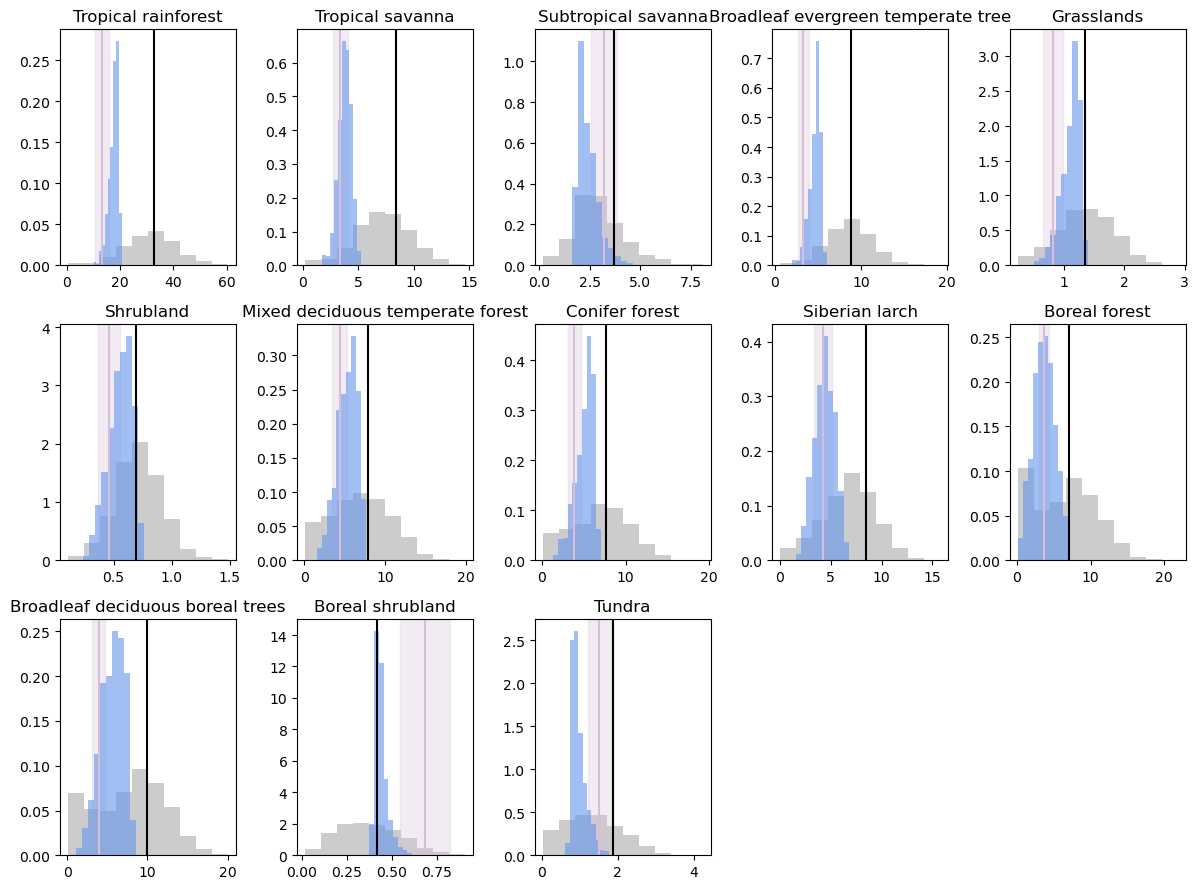

In [14]:
# emulate Biomass
emulator_dir = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave2_biome/emulators_biomebiomass/'

plt.figure(figsize=(12,9))
for b, biome in enumerate(biome_names[1:],start=1):
    plt.subplot(3,5,b)

    obs_mean = obs.biomassC_mean.sel(biome=b).values
    obs_var = obs.biomassC_stdev.sel(biome=b).values**2

    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = master_sample[cols][:1000]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.hist(biomass_lhc.isel(biome=b),color='grey',alpha=0.4,density=True)
    plt.axvspan(obs_mean-2*obs_var**0.5,obs_mean+2*obs_var**0.5,color='thistle',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    #plt.axvline(y_pred.numpy().flatten(),color='green')
    plt.axvline(biomass_lhc.isel(biome=b,ens=0),color='k')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue',density=True)
    
    plt.title(biome)

plt.tight_layout()

### Plot posteriors

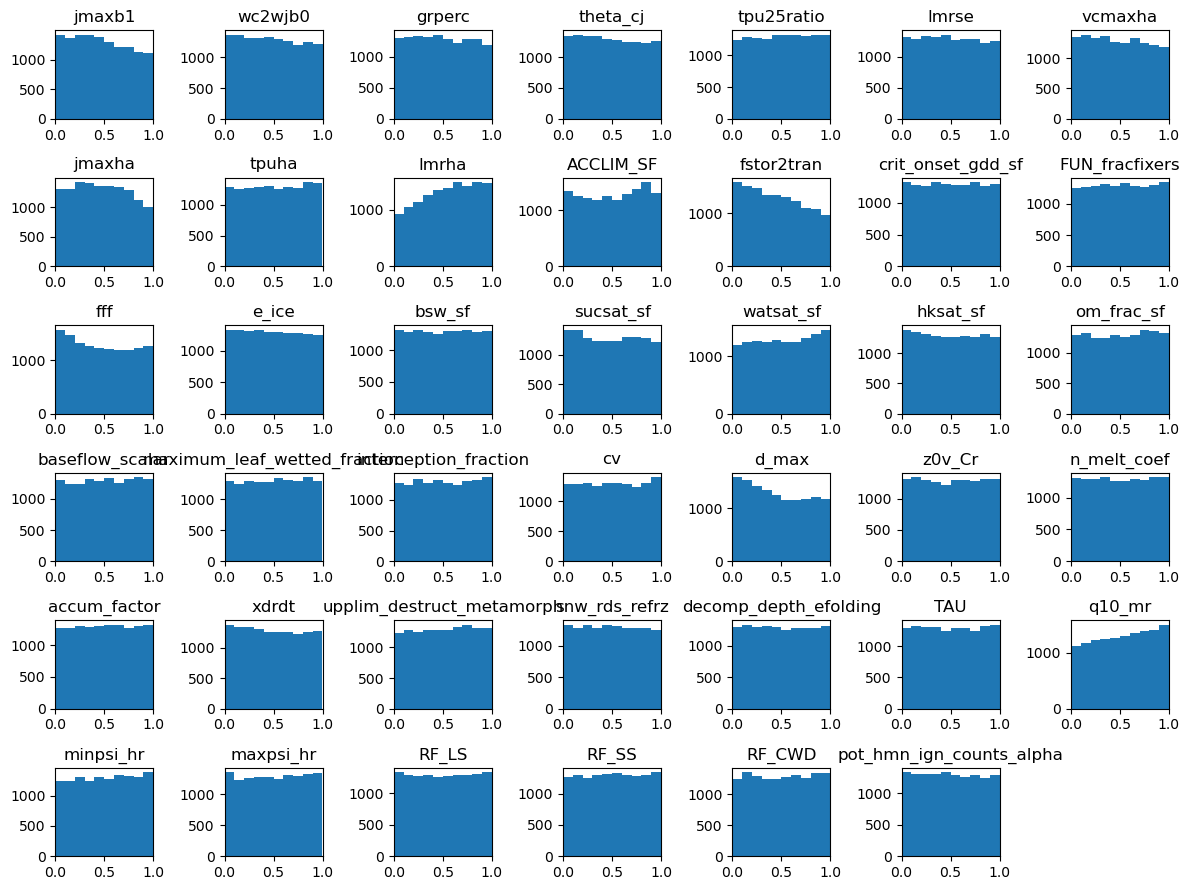

In [10]:
plt.figure(figsize=(12,9))
for i in range(len(u_params)):
    plt.subplot(6,7,i+1)
    plt.hist(master_sample[u_params[i]])
    plt.title(u_params[i])
    plt.xlim([0,1])
plt.tight_layout()
plt.savefig('./figs/posteriors_uparams_all.png')

In [ ]:
# PFT parameters by Biome

for pft in [1,2,3,4,5,6,7,8,10,11,12,13,14]:
    pft_param_names = [f"{param}_{pft}" for param in pft_params]
    plt.figure(figsize=(12,9))
    for i in range(len(pft_params)):
        plt.subplot(3,5,i+1)
        plt.hist(master_sample[pft_param_names[i]])
        plt.title(pft_param_names[i])
        plt.xlim([0,1])
    plt.tight_layout()
    plt.savefig('./figs/posteriors_pftparams_pft'+str(pft)+'.png')